In [1]:
import numpy as np
import os
import glob
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


## All features for Emiliani2 with target Emiliani2 VHI

In [4]:
target_region = 'Emiliani2'
csv_with_aggreg = "./features_with_aggregations_" + target_region + ".csv"

In [5]:
all_features = pd.read_csv(csv_with_aggreg).rename(columns={'Unnamed: 0': 'date'})

In [6]:
# merge with target values of Emiliani2
csv_target = "./csv/Emiliani2.csv"
target = pd.read_csv(csv_target).rename(columns={'Unnamed: 0': 'date'})

# remove dates not available in features
target = target[target['date'] <= all_features['date'].iloc[-1]]

target_df = pd.merge(all_features, target, on=['date'])['mean'].to_frame()

In [7]:
# remove the date column
features_df = all_features.iloc[:,1:]

In [8]:
idx_dic = {}
for col in features_df.columns:
    idx_dic[col] = features_df.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_Emiliani2_tg
1: cyclostationary_mean_Emiliani2_rr
2: cyclostationary_mean_Emiliani2_tg_1w
3: cyclostationary_mean_Emiliani2_tg_4w
4: cyclostationary_mean_Emiliani2_tg_8w
5: cyclostationary_mean_Emiliani2_tg_12w
6: cyclostationary_mean_Emiliani2_tg_16w
7: cyclostationary_mean_Emiliani2_tg_24w
8: cyclostationary_mean_Emiliani2_rr_1w
9: cyclostationary_mean_Emiliani2_rr_4w
10: cyclostationary_mean_Emiliani2_rr_8w
11: cyclostationary_mean_Emiliani2_rr_12w
12: cyclostationary_mean_Emiliani2_rr_16w
13: cyclostationary_mean_Emiliani2_rr_24w


## Linear Regression

The final interval is cut off to verify whether the final trend affects negatively the models performance

In [9]:
scaler_f = StandardScaler()
scaler_t = StandardScaler()

In [15]:
train_perc=0.42 # training data from 2001-01 to 2009-12 included
tot_rows = len(features_df)
# valid_perc = test_perc
valid_perc = 0.232 # validation data from 2010-01 to 2014-12 included, test until 2019-12 included

# 412 samples
features_train = features_df.iloc[0:int(tot_rows*train_perc)-1,:]
target_train = target_df.iloc[0:int(tot_rows*train_perc)-1,:]

# fit the scalers on training data
scaler_f.fit(features_train)
scaler_t.fit(target_train)

# scale all the dataset
features_df[features_df.columns] = scaler_f.transform(features_df[features_df.columns])
target_df[target_df.columns] = scaler_t.transform(target_df[target_df.columns])

X_train = features_df.iloc[0:int(tot_rows*train_perc)-1,:]
#228 samples for validation and for test
X_valid = features_df.iloc[int(tot_rows*train_perc)-1:int(tot_rows*(valid_perc+train_perc))]
X_test = features_df.iloc[int(tot_rows*(valid_perc+train_perc)):int(tot_rows*(valid_perc*2+train_perc))]

y_train = target_df.iloc[0:int(tot_rows*train_perc)-1,:]
y_valid = target_df.iloc[int(tot_rows*train_perc)-1:int(tot_rows*(valid_perc+train_perc))]
y_test = target_df.iloc[int(tot_rows*(valid_perc+train_perc)):int(tot_rows*(valid_perc*2+train_perc))]

X_train_valid = pd.concat([X_train, X_valid])
y_train_valid = pd.concat([y_train,y_valid])

print("The last ", round(1-(train_perc+valid_perc*2),2),"% of data is left unused,", 
      tot_rows - int(tot_rows*(valid_perc*2+train_perc)),"samples")

print("Total numer of samples used: ", round(len(features_df) * (train_perc + 2*valid_perc)))
print("Train samples: ", len(y_train))
print("Validation samples and test samples: ", len(y_valid))
print("Training and validation samples: ", len(y_train_valid))
print("Training data from 2001-01 to 2009-12 included, train %: ", train_perc)
print("Valid data from 2010-01 to 2014-12 included, test until 2019-12 included, % each: ", valid_perc)

The last  0.12 % of data is left unused, 114 samples
Total numer of samples used:  867
Train samples:  411
Validation samples and test samples:  228
Training and validation samples:  639
Training data from 2001-01 to 2009-12 included, train %:  0.42
Valid data from 2010-01 to 2014-12 included, test until 2019-12 included, % each:  0.232


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# tutte le features
X_train_all = X_train_valid
X_test_all = X_test

reg = LinearRegression().fit(X_train_all, y_train_valid)
print("Linear Regression : ")
print("R2_train: ", round(reg.score(X_train_all, y_train_valid),3))
print("R2_test: ", round(reg.score(X_test_all, y_test),3))
print("MAE: ", round(mean_absolute_error(y_test,reg.predict(X_test_all)),3))
print("MSE: ", round(mean_squared_error(y_test,reg.predict(X_test_all),squared=False),3))
print('\n')

# delta grande, k piccola
X_train_chosenfeat = X_train_all.iloc[:,[0, 10, 11, 2, 7, 9]]
X_test_chosenfeat = X_test_all.iloc[:,[0, 10, 11, 2, 7, 9]]
reg = LinearRegression().fit(X_train_chosenfeat, y_train_valid)
print("R2_train: ", reg.score(X_train_chosenfeat, y_train_valid))
print("R2_test: ", reg.score(X_test_chosenfeat, y_test))
print("MAE: ", mean_absolute_error(y_test,reg.predict(X_test_chosenfeat)))
print("MSE: ", mean_squared_error(y_test,reg.predict(X_test_chosenfeat),squared=False))

Linear Regression : 
R2_train:  0.219
R2_test:  0.25
MAE:  0.574
MSE:  0.719


R2_train:  0.2082802076217618
R2_test:  0.2412688576296559
MAE:  0.5768333535944483
MSE:  0.7227476819814798


R2_train slightly worse, less overfit capacity but R2_test duplicated

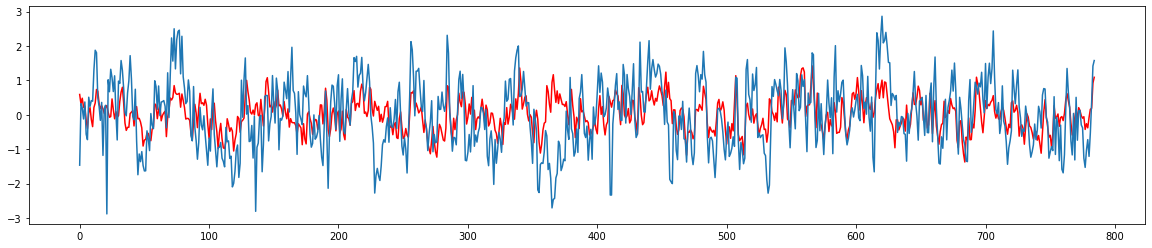

In [ ]:
# training prediction before

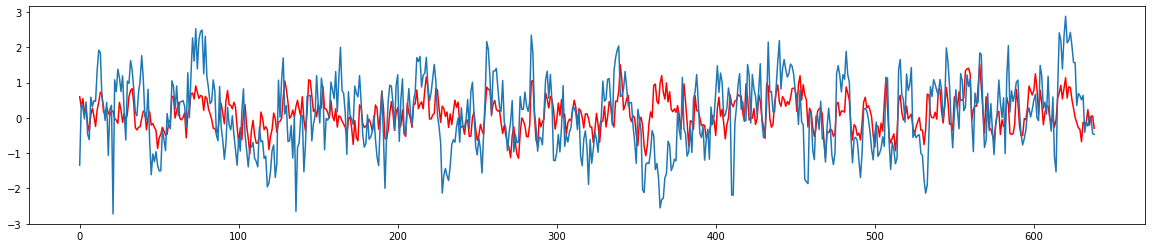

In [ ]:
reg = LinearRegression().fit(X_train_all, y_train_valid)
# plot prediction on train
prediction = reg.predict(X_train_all)

plt.plot(prediction, color='red')
plt.plot(y_train_valid)

plt.rcParams["figure.figsize"] = (20,4)
plt.show()

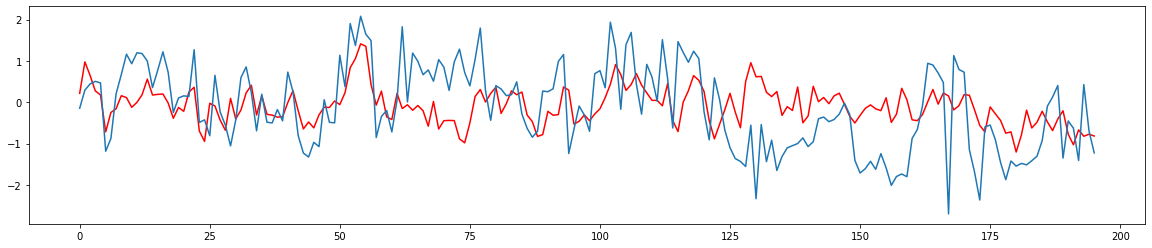

In [ ]:
# test prediction before

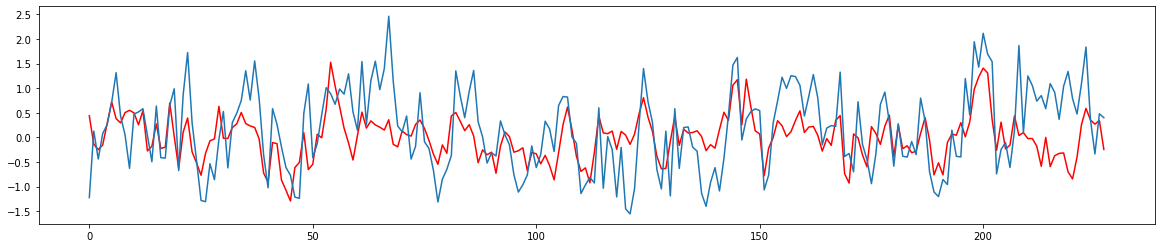

In [ ]:
prediction = reg.predict(X_test_all)

plt.plot(prediction, color='red')
y_test.reset_index(drop = True, inplace = True)
plt.plot(y_test)

plt.rcParams["figure.figsize"] = (15,4)
plt.show()

# Non linear models

## Imports and functions

In [32]:
! pip install tensorflow_addons
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow_addons.metrics import RSquare
from sklearn.model_selection import GridSearchCV

np.random.seed(1724)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
def feed_forward(num_units):
  # learning rate
  lr = 1e-3

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(units=num_units, activation=tf.keras.activations.relu))
  model.add(tf.keras.layers.Dense(units = 1))

  metrics = [tf.keras.metrics.MeanAbsoluteError()]

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
                loss='mse',
                metrics=metrics)
  
  return model

## With all features

### Extra Tree Regressor

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 120, num = 40)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
# bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

In [ ]:
ext = ExtraTreesRegressor(random_state=42)

opt = GridSearchCV(estimator=ext, param_grid = param_grid, verbose = 2)

# GridSearchCV already does 5-fold cross validation by default,
# so I take both train and validation data
opt.fit(X_train_valid.values, y_train_valid.values.ravel())

In [ ]:
opt.best_params_

{'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 80}

In [19]:
rfc= ExtraTreesRegressor(random_state=42, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 80)

rfc.fit(X_train_valid.values, y_train_valid.values.ravel())

ExtraTreesRegressor(n_estimators=80, random_state=42)

In [25]:
rf_mae = mean_absolute_error(y_test.values.ravel(), rfc.predict(X_test.values))
rf_mse = mean_squared_error(y_test.values.ravel(), rfc.predict(X_test.values))
r2_test = rfc.score(X_test.values, y_test.values.ravel())
r2_train = rfc.score(X_train_valid.values, y_train_valid.values.ravel())

print(" ExtraTreesRegressor: ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","R2_test: ",round(r2_test,3), "\n", "R2_train: ", round(r2_train,3))

 ExtraTreesRegressor: 
 MAE:  0.578 
 MSE:  0.524 
 R2_test:  0.238 
 R2_train:  1.0


### FFNN

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

ffnn_val = feed_forward(4)

hist_val = ffnn_val.fit(X_train.values, y_train.values, shuffle=False, epochs=300, 
                        validation_data=(X_valid.values, y_valid.values), verbose = 0)

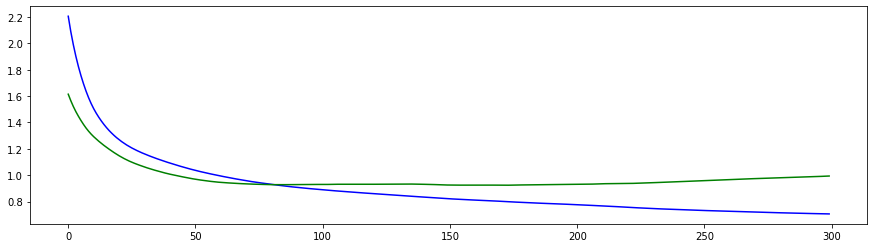

In [ ]:
plt.plot(hist_val.history['loss'], 'b')
plt.plot(hist_val.history['val_loss'],'g')

In [48]:
ffnn = feed_forward(4)
ffnn.fit(X_train_valid, y_train_valid, shuffle=False, epochs=85, verbose = 0)

In [49]:
ffnn_MAE = mean_absolute_error(y_test.values, ffnn.predict(X_test.values))
ffnn_MSE = mean_squared_error(y_test.values, ffnn.predict(X_test.values))

metric = RSquare()
metric.update_state(y_test.values, ffnn.predict(X_test.values))
r2_test = metric.result()
r2_test.numpy()

metric = RSquare()
metric.update_state(y_train_valid, ffnn.predict(X_train_valid))
r2_train = metric.result()
r2_train.numpy()
print (" FFNN:")
print(" MAE: ", round(ffnn_MAE,3), "\n", "MSE: ", round(ffnn_MSE,3), "\n",
      "R2_test: ",round(r2_test.numpy(),3), "\n", "R2_train: ", round(r2_train.numpy(),3))

20/20 [==============================] - 0s 1ms/step
 FFNN:
 MAE:  0.6 
 MSE:  0.549 
 R2_test:  0.203 
 R2_train:  0.248


#Graphs

In [ ]:
reg = LinearRegression().fit(X_train, y_train)

7/7 [==============================] - 0s 2ms/step


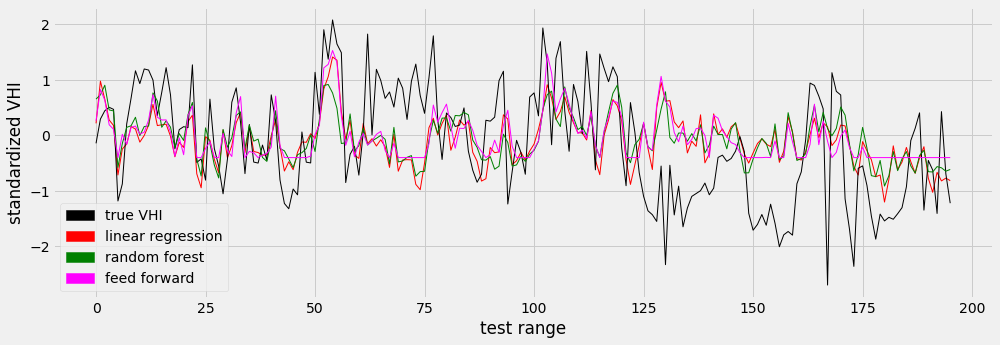

In [ ]:
#before

8/8 [==============================] - 0s 2ms/step


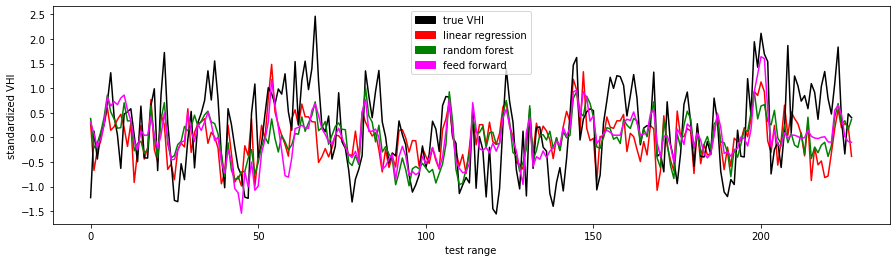

In [ ]:
import matplotlib.patches as mpatches

prediction = reg.predict(X_test)

plt.plot(prediction, color='red')
y_test.reset_index(drop = True, inplace = True)
plt.plot(y_test, color='black')
random_forest = rfc.predict(X_test.values)
plt.plot(random_forest, color='green')
ffnn_pred = ffnn.predict(X_test.values)
plt.plot(ffnn_pred, color='magenta')

plt.xlabel("test range")
plt.ylabel("standardized VHI")

black_patch = mpatches.Patch(color='black', label='true VHI')
red_patch = mpatches.Patch(color='red', label='linear regression')
green_patch = mpatches.Patch(color='green', label='random forest')
magenta_patch = mpatches.Patch(color='magenta', label='feed forward')

plt.legend(handles=[black_patch, red_patch,green_patch, magenta_patch])

plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['lines.linewidth'] = 1
plt.show()

20/20 [==============================] - 0s 4ms/step


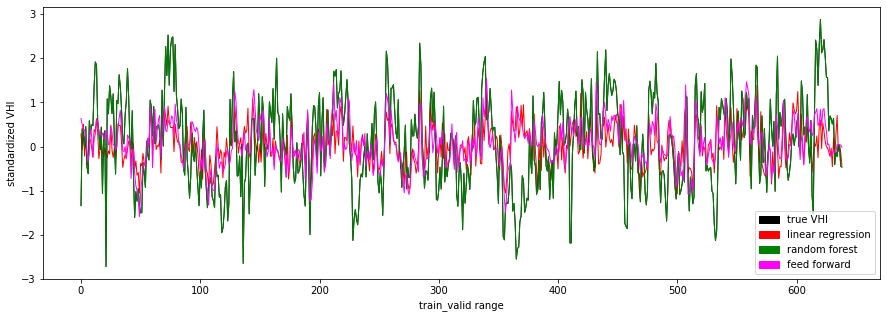

In [ ]:
prediction = reg.predict(X_train_valid)
plt.plot(prediction, color='red')
y_train.reset_index(drop = True, inplace = True)
plt.plot(y_train_valid, color='black')
random_forest = rfc.predict(X_train_valid.values)
plt.plot(random_forest, color='green')
ffnn_pred = ffnn.predict(X_train_valid.values)
plt.plot(ffnn_pred, color='magenta')

plt.xlabel("train_valid range")
plt.ylabel("standardized VHI")

black_patch = mpatches.Patch(color='black', label='true VHI')
red_patch = mpatches.Patch(color='red', label='linear regression')
green_patch = mpatches.Patch(color='green', label='random forest')
magenta_patch = mpatches.Patch(color='magenta', label='feed forward')

plt.legend(handles=[black_patch, red_patch,green_patch, magenta_patch])
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['lines.linewidth'] = 1
plt.show()

# results

#### **All the features:**     
regression: R2: 0.0319, MAE: 0.804     
extra tree regressor: R2 0.0559, MAE 0.793  
FFNN: R2 0.0265, MAE 0.786  
#### **Chosen features without aggregation:**
best group of features found (3/20):  
3: Piemonte_Sud_tg  
12: Emiliani1_rr   
1: Dora_tg  
regression:  R2: 0.0721, MAE: 0.789    
extra tree regressor: R2 0.0558, MAE 0.794     
FFNN: R2 0.06, MAE 0.784        
#### **Chosen features with aggregation:**
best group of features found (4/140):  
93: Emiliani1_rr_4w,  
68: Lambro_Olona_tg_1w,  
131: Lambro_Olona_rr_12w,   
110: Oglio_Iseo_rr_1w,    
regression:  R2_train: 0.237, R2_test: 0.13, MAE: 0.74  
extra tree regressor: R2_train: 0.7185, R2_test: 0.174, MAE: 0.739   
FFNN: R2_train: 0.313, R2_test: 0.136, MAE: 0.756  
#### **All features with aggreg only of target (Emi2)**  
regression:  R2_train:  0.2355, R2_test:  0.1074, MAE:  0.7668  
extra tree regressor: R2_train: 0.83, R2_test  0.197, MAE: 0.7288  
FFNN: R2_train: 0.32, R2_test: 0.13, MAE: 0.75  
#### **Chosen features, aggreg, only of target (Emi2)** 
best group of features found (6/20):  
0: Emiliani2_tg  
10: Emiliani2_rr_8w  
11: Emiliani2_rr_12w  
2: Emiliani2_tg_1w  
7: Emiliani2_tg_24w  
9: Emiliani2_rr_4w  
regression: R2_train: 0.2258, R2_test: 0.113, MAE: 0.766  
extra tree regressor: R2_train: 0.71, R2_test: 0.13, MAE: 0.74  
FFNN: R2_train: 0.23, R2_test: 0.16, MAE: 0.74    
#### **Chosen features, aggreg, classification:** 
93: Emiliani1_rr_4w, importance in random forest: 0.29  
68: Lambro_Olona_tg_1w, imp: 0.27  
131: Lambro_Olona_rr_12w, imp: 0.26  
110: Oglio_Iseo_rr_1w, imp: 0.18  
extra tree classifier: acc_test: 0.4643 acc_train: 0.959 MAE: 0.622  
FFNN: acc_test: 0.43 acc_train: 0.52 MAE: 0.408